# Chessbot in python using RL

## Inhoudstafel
1. Complexiteit van schaken
2. Vergelijking tussen oude en nieuwe schaakbots
3. Minimax algoritme en optimalisatietechnieken
4. Neuraal Netwerk
5. Monte Carlo Tree Search (MCTS)
6. Demonstratie van de prestaties van mijn schaakbot

## 1. Complexiteit van schaken

Shannon's number: een schatting van de grootte van de zoekboom in schaken

**10^120**


| Zetten | Posities |
| :- | -: |
| 1 | 20 |
| 2 | 400 |
| 3 | 8,902 |
| 4 | 197,281 |
| 5 | 4,865,609 |
| 10 | 69,352,589,712,417 |
| 15 | 2,015,099,950,053,364,471,960 |

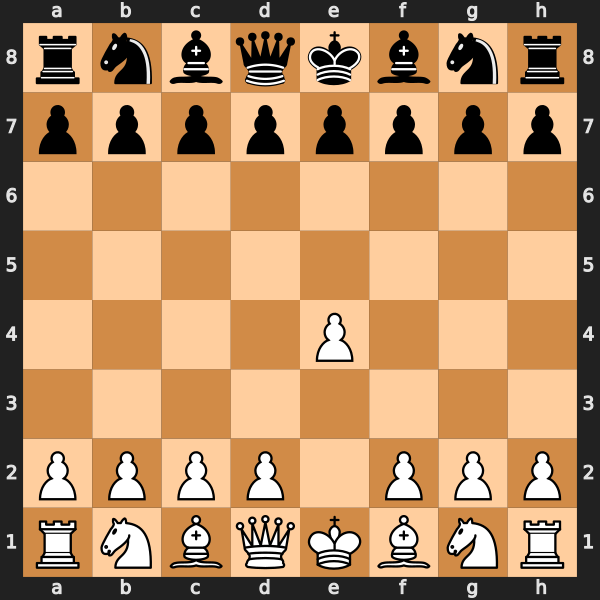

In [26]:
import chess
import chess.svg
from IPython.display import display, clear_output
import time

def show_move(board, move, size=600):
    # make the move
    uci_move = chess.Move.from_uci(move)
    board.push(uci_move)
    clear_output(wait=True)
    display(chess.svg.board(board=board, size=size))
    time.sleep(0.2)
    board.pop()
    return board

legal_moves = list("a2a3 b2b3 c2c3 d2d3 e2e3 f2f3 g2g3 h2h3 a2a4 b2b4 c2c4 d2d4 e2e4 f2f4 g2g4 h2h4 b1a3 b1c3 g1f3 g1h3 e2e4".split())

board = chess.Board()
for move in legal_moves:
    board = show_move(board, move)

## 2. vergelijking tussen oude en nieuwe schaakbots

### Deep Blue (IBM)
- gebaseerd op Minimax-algoritme
- beperkte zoekdiepte
- veel regels en specifieke schaakkennis
- geen mogelijkheid om te leren van eerdere spelen en te verbeteren

### AlphaZero (Google)
- gebaseerd op ML en NN
- geen schaakkennis
- maakt gebruik van MCTS
- van zichzelf leren en aanpassen

## 3. Minimax algoritme en optimalisatietechnieken

### Minimax
algoritme waarbij de zet genomen wordt dat de tegenstander het minste voordeel heeft

<img src="img/AB_Pruning.svg" width="1200" height="600">

### Optimalizatie technieken
**Alpha-Beta Pruning**
```python
if alpha >= beta:
    if verbose == 3: print("snip because" + str(alpha) + " >= " + str(beta))
    break # beta cut-off
```


**Move ordering**
```python
def order_moves(board):
    legal_moves = list(board.legal_moves)
    def sort_moves(move, board):
        movescoregeuss = 0
        if board.gives_check(move):
            movescoregeuss += 1000
        try:
            if board.is_capture(move):
                captured_piece = board.piece_at(move.to_square)
                attacking_piece = board.piece_at(move.from_square)
                if not attacking_piece or not captured_piece:
                    return movescoregeuss
                if attacking_piece.piece_type < captured_piece.piece_type:
                    movescoregeuss += 20*(captured_piece.piece_type**2 - attacking_piece.piece_type**2)
                elif attacking_piece.piece_type > captured_piece.piece_type:
                    movescoregeuss += 10*(attacking_piece.piece_type**2 - captured_piece.piece_type**2)
                else:
                    movescoregeuss += 10
        except:
            pass
        if move.promotion is not None:
            movescoregeuss += 10
        return movescoregeuss
    legal_moves.sort(key=lambda move: sort_moves(move, board), reverse=True)
    return legal_moves

### Problemen met minimax
**Horizon Problem**: we zien niet verder dan de "horizon" (diepte van de tree)

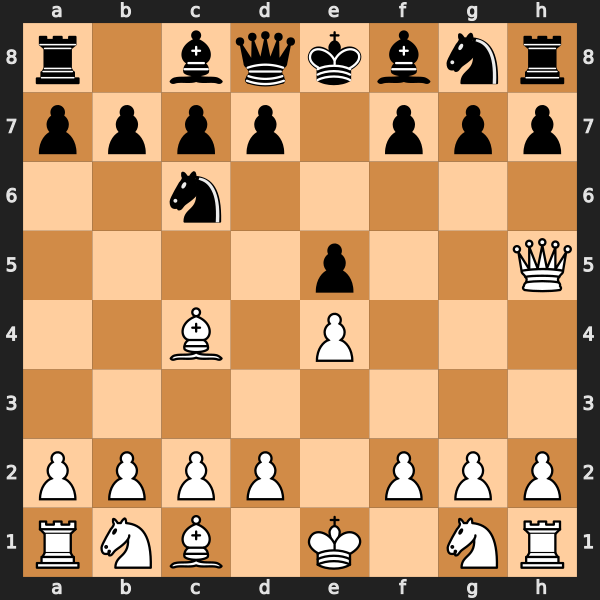

In [27]:
board = chess.Board("r1bqkbnr/pppp1ppp/2n5/4p2Q/2B1P3/8/PPPP1PPP/RNB1K1NR b KQkq - 3 3")
display(chess.svg.board(board=board, size=600))

**Heuristic values**: we hebben een functie nodig om schaakposities te evalueren

**Random moves**: geen opening strategie, doet maar wat

## 4. neuraal netwerk

Input: board representation

Output: Value & Probability distribution

In [28]:
import numpy as np
from keras.models import load_model
from enum import Enum
from chess import PieceType
from typing import Tuple
import threading

def one_hot_encode_board(board: chess.Board) -> np.ndarray:
    one_hot_board = np.zeros((8, 8, 119))

    for i in range(8):
        for j in range(8):
            piece = board.piece_at(i*8+j)
            if piece:
                if piece.color == chess.WHITE:
                    one_hot_board[i][j][piece.piece_type - 1] = 1
                else:
                    one_hot_board[i][j][6 + piece.piece_type - 1] = 1

    if board.has_kingside_castling_rights(chess.WHITE):
        one_hot_board[0][7][12] = 1
    if board.has_queenside_castling_rights(chess.WHITE):
        one_hot_board[0][7][13] = 1
    if board.has_kingside_castling_rights(chess.BLACK):
        one_hot_board[7][7][14] = 1
    if board.has_queenside_castling_rights(chess.BLACK):
        one_hot_board[7][7][15] = 1

    if board.ep_square:
        col = board.ep_square % 8
        row = board.ep_square // 8
        one_hot_board[row][col][16] = 1

    one_hot_board[:, :, 17] = board.halfmove_clock / 50

    return one_hot_board

class QueenDirection(Enum):
    # eight directions
    NORTHWEST = 0
    NORTH = 1
    NORTHEAST = 2
    EAST = 3
    SOUTHEAST = 4
    SOUTH = 5
    SOUTHWEST = 6
    WEST = 7


class KnightMove(Enum):
    # eight possible knight moves
    NORTH_LEFT = 0  # diff == -15
    NORTH_RIGHT = 1  # diff == -17
    EAST_UP = 2  # diff == -6
    EAST_DOWN = 3  # diff == 10
    SOUTH_RIGHT = 4  # diff == 15
    SOUTH_LEFT = 5  # diff == 17
    WEST_DOWN = 6  # diff == 6
    WEST_UP = 7  # diff == -10


class UnderPromotion(Enum):
    KNIGHT = 0
    BISHOP = 1
    ROOK = 2


class Mapping:
    """
    The mapper is a dictionary of moves.
    * the index is the type of move
    * the value is the plane's index, or an array of plane indices (for distance)
    """
    # knight moves from north_left to west_up (clockwise)
    knight_mappings = [-15, -17, -6, 10, 15, 17, 6, -10]

    def get_index(self, piece_type: PieceType, direction: Enum, distance: int = 1) -> int:
        if piece_type == PieceType.KNIGHT:
            return 56 + KnightMove(direction).value
        else:
            return QueenDirection(direction) * 8 + distance

    @staticmethod
    def get_underpromotion_move(piece_type: PieceType, from_square: int, to_square: int) -> Tuple[UnderPromotion, int]:
        piece_type = UnderPromotion(piece_type - 2)
        diff = from_square - to_square
        if to_square < 8:
            # black promotes (1st rank)
            direction = diff - 8
        elif to_square > 55:
            # white promotes (8th rank)
            direction = diff + 8
        return (piece_type, direction)

    @staticmethod
    def get_knight_move(from_square: int, to_square: int) -> KnightMove:
        return KnightMove(Mapping.knight_mappings.index(from_square - to_square))

    @staticmethod
    def get_queenlike_move(from_square: int, to_square: int) -> Tuple[QueenDirection, int]:
        diff = from_square - to_square
        if diff % 8 == 0:
            # north and south
            if diff > 0:
                direction = QueenDirection.SOUTH
            else:
                direction = QueenDirection.NORTH
            distance = int(diff / 8)
        elif diff % 9 == 0:
            # southwest and northeast
            if diff > 0:
                direction = QueenDirection.SOUTHWEST
            else:
                direction = QueenDirection.NORTHEAST
            distance = np.abs(int(diff / 8))
        elif from_square // 8 == to_square // 8:
            # east and west
            if diff > 0:
                direction = QueenDirection.WEST
            else:
                direction = QueenDirection.EAST
            distance = np.abs(diff)
        elif diff % 7 == 0:
            if diff > 0:
                direction = QueenDirection.SOUTHEAST
            else:
                direction = QueenDirection.NORTHWEST
            distance = np.abs(int(diff / 8)) + 1
        else:
            raise Exception("Invalid queen-like move")
        return (direction, distance)

    mapper = {
        # queens
        QueenDirection.NORTHWEST: [0, 1, 2, 3, 4, 5, 6],
        QueenDirection.NORTH: [7, 8, 9, 10, 11, 12, 13],
        QueenDirection.NORTHEAST: [14, 15, 16, 17, 18, 19, 20],
        QueenDirection.EAST: [21, 22, 23, 24, 25, 26, 27],
        QueenDirection.SOUTHEAST: [28, 29, 30, 31, 32, 33, 34],
        QueenDirection.SOUTH: [35, 36, 37, 38, 39, 40, 41],
        QueenDirection.SOUTHWEST: [42, 43, 44, 45, 46, 47, 48],
        QueenDirection.WEST: [49, 50, 51, 52, 53, 54, 55],
        # knights
        KnightMove.NORTH_LEFT: 56,
        KnightMove.NORTH_RIGHT: 57,
        KnightMove.EAST_UP: 58,
        KnightMove.EAST_DOWN: 59,
        KnightMove.SOUTH_RIGHT: 60,
        KnightMove.SOUTH_LEFT: 61,
        KnightMove.WEST_DOWN: 62,
        KnightMove.WEST_UP: 63,
        # underpromotions
        UnderPromotion.KNIGHT: [64, 65, 66],
        UnderPromotion.BISHOP: [67, 68, 69],
        UnderPromotion.ROOK: [70, 71, 72]
    }

class ChessMoveMapper():
    def __init__(self, board, policy):
        self.outputs = []
        self.actions = {}
        self.board = board
        self.policy = policy

    def map_valid_move(self, move) -> None:
        """
        Input: a valid move generated by the chess library.
        Will add the move to the output vector, along with its plane, column, and row
        """
        from_square = move.from_square
        to_square = move.to_square

        plane_index: int = None
        piece = self.board.piece_at(from_square)
        direction = None

        if piece is None:
            raise Exception(f"No piece at {from_square}")

        if move.promotion and move.promotion != chess.QUEEN:
            piece_type, direction = Mapping.get_underpromotion_move(
                move.promotion, from_square, to_square)
            plane_index = Mapping.mapper[piece_type][1 - direction]
        else:
            # find the correct plane based on from_square and move_square
            if piece.piece_type == chess.KNIGHT:
                # get direction
                direction = Mapping.get_knight_move(from_square, to_square)
                plane_index = Mapping.mapper[direction]
            else:
                # get direction of queen-type move
                direction, distance = Mapping.get_queenlike_move(
                    from_square, to_square)
                plane_index = Mapping.mapper[direction][np.abs(distance)-1]
        # create a mask with only valid moves
        row = from_square % 8
        col = 7 - (from_square // 8)
        self.outputs.append((move, plane_index, row, col))

    def probabilities_to_actions(self) -> dict:
        """
        Map the output vector of 4672 probabilities to moves. Returns a dictionary of moves and their probabilities.
        The output vector is a list of probabilities for every move
        * 4672 probabilities = 73*64 => 73 planes of 8x8
        The squares in these 8x8 planes indicate the square where the piece is.
        The plane itself indicates the type of move:
            - first 56 planes: queen moves (length of 7 squares * 8 directions)
            - next 8 planes: knight moves (8 directions)
            - final 9 planes: underpromotions (left diagonal, right diagonal, forward) * (three possible pieces (knight, bishop, rook))
        """
        probabilities = self.policy.reshape(73, 8, 8)
        # mask = np.zeros((config.amount_of_planes, config.n, config.n))

        # only get valid moves
        valid_moves = self.board.generate_legal_moves()
        outputs = []
        # use threading to map valid moves quicker
        threads = []
        while True:
            try:
                move = next(valid_moves)
            except StopIteration:
                break
            thread = threading.Thread(
                target=self.map_valid_move, args=(move,))
            threads.append(thread)
            thread.start()

        # wait until all threads are done
        for thread in threads:
            thread.join()

        for x in self.outputs:
            self.actions[x[0].uci()] = probabilities[int(x[1])][int(x[2])][int(x[3])]
            # self.actions[x[0].uci()] = int(probabilities[int(x[1])][int(x[2])][int(x[3])])
            # self.actions.append([x[0].uci() , probabilities[int(x[1])][int(x[2])][int(x[3])]])
        # for move, plane_index, col, row in outputs:
        #     # mask[plane_index][col][row] = 1
        #     print(f"move: {move}, plane: {plane_index}, col: {col}, row: {row}")
        #     self.actions[move.uci()] = probabilities[plane_index][col][row]

        return self.actions
    

1/1 [==============================] - 0s 177ms/step
move: e2e4, probability: 0.5596699118614197
move: d2d4, probability: 0.16275088489055634
move: g1f3, probability: 0.08700816333293915
move: g2g3, probability: 0.06883305311203003
move: c2c4, probability: 0.05882731452584267
move: b2b3, probability: 0.02249414287507534
move: e2e3, probability: 0.01195710338652134
move: b1c3, probability: 0.0077949403785169125
move: d2d3, probability: 0.004942777566611767
move: h2h3, probability: 0.003348242025822401
move: b2b4, probability: 0.003022058866918087
move: g2g4, probability: 0.0015726364217698574
move: f2f3, probability: 0.0012242847587913275
move: c2c3, probability: 0.0008072126656770706
move: f2f4, probability: 0.000307214300846681
move: h2h4, probability: 4.957444980391301e-05
move: a2a3, probability: 2.953705916297622e-05
move: a2a4, probability: 9.914208931149915e-06
move: b1a3, probability: 5.876130870774432e-08
move: g1h3, probability: 1.625287238127271e-09


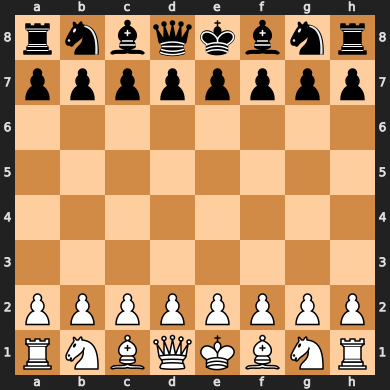

In [29]:
board = chess.Board()
board_input = np.expand_dims(one_hot_encode_board(board), axis=0)

model = load_model("Models/chessbot_neural_network.h5")

# predict the move
value, policy = model.predict(board_input)

# map the probabilities to the legal moves
MoveMapper = ChessMoveMapper(board, policy)

actions = MoveMapper.probabilities_to_actions()

# sort the actions by probability
actions = sorted(actions.items(), key=lambda x: x[1], reverse=True)

# print the actions
for action in actions:
    print(f"move: {action[0]}, probability: {action[1]}")

display(board)

## 5. MCTS

**MCTS**: algoritme dat simulaties gebruikt om de beste keuze te vinden

<img src="img/MCTS_steps.png" width="1600" height="600">

```python
def upper_confidence_bound(self, noise: float) -> float:
        exploration_rate = math.log((1 + self.input_node.N + 20000) / 20000) + 2
        ucb = exploration_rate * (self.P * noise) * (math.sqrt(self.input_node.N) / (1 + self.N))
        if self.input_node.turn == chess.WHITE:
            return self.W / (self.N + 1) + ucb 
        else:
            return -(self.W / (self.N + 1)) + ucb

```python
while True:
  print("playing games against itself")

  pool = multiprocessing.Pool(processes=40)
  results = pool.map(self_play, range(200))

  train_model()

  print("playing games against new model")

  result = play_test_games()

  if sum(result) < 0:
    print("new model outperformed old one deleting dataset and saving new model as main one")

    for game in os.listdir("Memory"):
        os.remove(os.path.join("Memory", game))

    model = load_model("Models/chessbot_neural_network_v2.h5")
    model.save("Models/chessbot_neural_network.h5")

  else:
    print("old model outperformed new one, playing some more games to get more training data")

## 6. Spel tegen schaakbot

<a href="https://lichess.org/analysis">Lichess</a>



[Event "bot Game"]
[Site "offline vscode"]
[Date "2023.01.30"]
[Round "1"]
[White "flor werbrouck"]
[Black "bot"]
[Result "1-0"]

1. e4 Nc6 2. Nc3 e5 3. Nf3 f6 4. Bc4 Be7 5. O-O a6 6. d3 d6 7. Be3 a5 8. Qd2 Bg4 9. Qe2 g6 10. h3 Bxh3 11. gxh3 Nd4 12. Bxd4 Qd7 13. Kh2 a4 14. Be3 b6 15. d4 d5 16. exd5 O-O-O 17. dxe5 Kb8 18. e6 h6 19. exd7 Rxd7 20. Bb5 g5 21. Bxd7 g4 22. hxg4 a3 23. Qa6 Bd6+ 24. Kg2 b5 25. Bc6 Bf4 26. Qb7#